# Data Augmentation with Mixup

## [Introduction](https://keras.io/examples/vision/mixup/)
**Mixup** is a *domain-agnostic* data augmentation technique proposed in [mixup: Beyond Empirical Risk Minimization](https://arxiv.org/abs/1710.09412) by Zhang et al. It's implemented with the following formulas:
$$
\overline{x} = \lambda x_{i} + (1-\lambda)x_{j}
$$
$$
\overline{y} = \lambda y_{i} + (1-\lambda)y_{j}
$$
(Note that the lambda values are values with the `[0, 1]` range and are sampled from the [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution).)

The technique is quite systematically named - we are literally mixing up the features and their corresponding labels. Implementation-wise it's simple. Neural networks are prone to [memorizing corrupt labels](https://arxiv.org/abs/1611.03530). mixup relaxes this by combining different features with one another (same happens for the labels too) so that a network does not get overconfident about the relationship between the features and their labels.

mixup is specifically useful when we are not sure about selecting a set of augmentation transforms for a given dataset, medical imaging datasets, for example. mixup can be extended to a variety of data modalities such as computer vision, natural language processing, speech, and so on.

This  requires TensorFlow 2.4 or higher.

---

In [15]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Read files

In [3]:
def_front = glob.glob('/Users/piyush/Sandbox/Assignment_03/dataset/casting_data/train/def_front/*.*')
ok_front = glob.glob('/Users/piyush/Sandbox/Assignment_03/dataset/casting_data/train/ok_front/*.*')

In [2]:
data = []
labels = []

In [4]:
for i in def_front:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='grayscale', 
    target_size= (28,28))
    image=np.array(image)
    data.append(image)
    labels.append(0)

for i in ok_front:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='grayscale', 
    target_size= (28,28))
    image=np.array(image)
    data.append(image)
    labels.append(1)


In [8]:
data = np.array(data)
labels = np.array(labels, dtype=np.uint8)

## Split dataset

In [70]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [71]:
x_train = x_train.astype("float32") / 255.0
x_train = np.reshape(x_train, (-1, 28, 28, 1))
y_train = tf.one_hot(y_train, 2)

x_test = x_test.astype("float32") / 255.0
x_test = np.reshape(x_test, (-1, 28, 28, 1))
y_test = tf.one_hot(y_test, 2)

In [72]:
print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))

5306
5306
1327
1327


In [73]:
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 32
EPOCHS = 1

## Shuffle dataset

In [74]:
train_ds_one = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(BATCH_SIZE * 10)
    .batch(BATCH_SIZE)
)
train_ds_two = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(BATCH_SIZE * 10)
    .batch(BATCH_SIZE)
)

In [75]:
train_ds = tf.data.Dataset.zip((train_ds_one, train_ds_two))

In [76]:
val_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

## Mixup functions

In [77]:
def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


def mix_up(ds_one, ds_two, alpha=0.2):
    # Unpack two datasets
    images_one, labels_one = ds_one
    images_two, labels_two = ds_two
    batch_size = tf.shape(images_one)[0]

    # Sample lambda and reshape it to do the mixup
    l = sample_beta_distribution(batch_size, alpha, alpha)
    x_l = tf.reshape(l, (batch_size, 1, 1, 1))
    y_l = tf.reshape(l, (batch_size, 1))

    # Perform mixup on both images and labels by combining a pair of images/labels
    # (one from each dataset) into one image/label
    images = images_one * x_l + images_two * (1 - x_l)
    labels = labels_one * y_l + labels_two * (1 - y_l)
    return (images, labels)

In [78]:
# First create the new dataset using our `mix_up` utility
train_ds_mu = train_ds.map(
    lambda ds_one, ds_two: mix_up(ds_one, ds_two, alpha=0.2), num_parallel_calls=AUTO
)

## Preview mixup images

[0.015348970890045166, 0.9846510291099548]
[1.0, 0.0]
[0.049706265330314636, 0.9502937197685242]
[0.13321369886398315, 0.8667863011360168]
[0.0, 1.0]
[0.9996296763420105, 0.00037032098043709993]
[1.0, 0.0]
[1.0, 0.0]
[1.0, 0.0]


[]

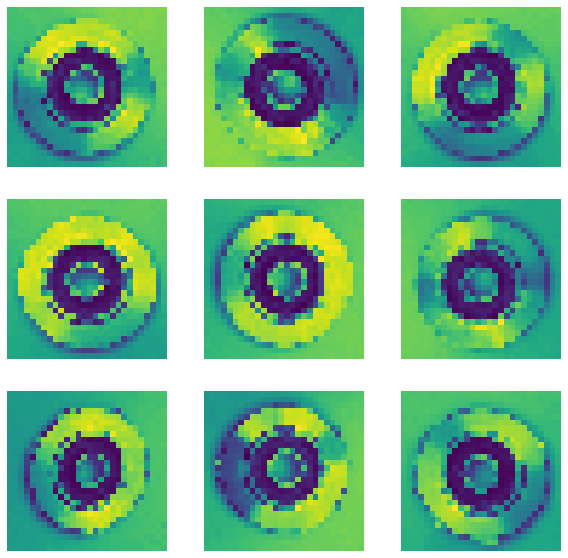

In [79]:
# Let's preview 9 samples from the dataset
sample_images, sample_labels = next(iter(train_ds_mu))
plt.figure(figsize=(10, 10))
plt.title("Data Augmentation using Mixup")
for i, (image, label) in enumerate(zip(sample_images[:9], sample_labels[:9])):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().squeeze())
    print(label.numpy().tolist())
    plt.axis("off")
plt.plot()
# plt.savefig(r"C:\Users\PiyushAnand\Desktop\CNN\images\mixup.jpg")

## Train Model

In [80]:
def get_training_model():
    model = tf.keras.Sequential(
        [
            layers.Conv2D(16, (5, 5), activation="relu", input_shape=(28, 28, 1)),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(32, (5, 5), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Dropout(0.2),
            layers.GlobalAvgPool2D(),
            layers.Dense(128, activation="relu"),
            layers.Dense(2, activation="softmax"), # Change softmax / sigmoid
        ]
    )
    return model

In [81]:
initial_model = get_training_model()
initial_model.save_weights("initial_weights_mixup_wed_30x30.h5")

In [82]:
model = get_training_model()
model.load_weights("initial_weights_mixup_wed_30x30.h5")
model.compile(
    loss="categorical_crossentropy", 
    # loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="adam", metrics=["accuracy"]) # categorical_crossentropy / binary_crossentropy / sparse_categorical_crossentropy
model.fit(train_ds_mu, validation_data=val_ds, epochs=15)



Epoch 1/15
166/166 [==============================] - 4s 18ms/step - loss: 0.6857 - accuracy: 0.5637 - val_loss: 0.6761 - val_accuracy: 0.5863
Epoch 2/15
166/166 [==============================] - 2s 15ms/step - loss: 0.6747 - accuracy: 0.5695 - val_loss: 0.6117 - val_accuracy: 0.6044
Epoch 3/15
166/166 [==============================] - 3s 15ms/step - loss: 0.5917 - accuracy: 0.6834 - val_loss: 0.4869 - val_accuracy: 0.7430
Epoch 4/15
166/166 [==============================] - 3s 15ms/step - loss: 0.4907 - accuracy: 0.7720 - val_loss: 0.3699 - val_accuracy: 0.8455
Epoch 5/15
166/166 [==============================] - 3s 18ms/step - loss: 0.4332 - accuracy: 0.8151 - val_loss: 0.3107 - val_accuracy: 0.8862
Epoch 6/15
166/166 [==============================] - 3s 16ms/step - loss: 0.4191 - accuracy: 0.8243 - val_loss: 0.2978 - val_accuracy: 0.8659
Epoch 7/15
166/166 [==============================] - 3s 18ms/step - loss: 0.3869 - accuracy: 0.8545 - val_loss: 0.3049 - val_accuracy: 0.8757

## Model Train Result

Accuracy : 88%

## Visualize Training

In [86]:
import seaborn as sns
sns.set()

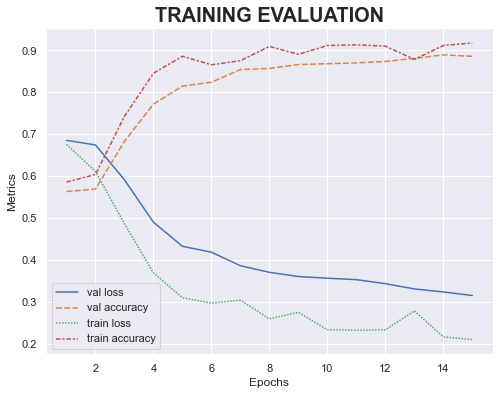

In [87]:
import seaborn as sns
sns.set()
plt.subplots(figsize = (8, 6))
sns.lineplot(data = pd.DataFrame(model.history.history,
                                 index = range(1, 1+len(model.history.epoch))))
plt.title("TRAINING EVALUATION", fontweight = "bold", fontsize = 20)
plt.xlabel("Epochs")
plt.ylabel("Metrics")

plt.legend(labels = ['val loss', 'val accuracy', 'train loss', 'train accuracy'])
plt.show()

## Test on test dataset

In [16]:
def_front_test = glob.glob('/Users/piyush/Sandbox/Assignment_03/dataset/casting_data/train/def_front/*.*')
ok_front_test = glob.glob('/Users/piyush/Sandbox/Assignment_03/dataset/casting_data/train/ok_front/*.*')

data_test = []
labels_test = []

for i in def_front_test:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='grayscale', 
    target_size= (28,28))
    image=np.array(image)
    data_test.append(image)
    labels_test.append(0)

for i in ok_front_test:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='grayscale', 
    target_size= (28,28))
    image=np.array(image)
    data_test.append(image)
    labels_test.append(1)

data_test = np.array(data_test)
labels_test = np.array(labels_test, dtype=np.uint8)

data_test = data_test.astype("float32") / 255.0
data_test = np.reshape(data_test, (-1, 28, 28, 1))
labels_test = tf.one_hot(labels_test, 2)


test_ds = tf.data.Dataset.from_tensor_slices((data_test, labels_test)).batch(32)

2022-07-14 22:41:04.961879: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [89]:
_, test_acc = model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

208/208 [==============================] - 1s 5ms/step - loss: 0.1939 - accuracy: 0.9329
Test accuracy: 93.29%


## Test Accuracy

Accuracy : 93%

In [90]:
model.save('/Users/piyush/Sandbox/Assignment_03/notebooks/mixup')

INFO:tensorflow:Assets written to: /Users/piyush/Sandbox/Assignment_03/notebooks/mixup/assets


INFO:tensorflow:Assets written to: /Users/piyush/Sandbox/Assignment_03/notebooks/mixup/assets


## Predict sample for one image

In [ ]:
model_mixup = tf.keras.models.load_model("/Users/piyush/Sandbox/API_03/models/mixup")

In [72]:
image=tf.keras.preprocessing.image.load_img("/Users/piyush/Sandbox/Assignment_03/dataset/casting_data/test/def_front/cast_def_0_242.jpeg", color_mode='grayscale', target_size= (28,28))
image=np.array(image)
image = image.astype("float32") / 255.0
image = np.reshape(image, (-1, 28, 28, 1))

In [75]:
pred = model_mixup.predict(image)

1/1 [==============================] - 0s 52ms/step


In [76]:
pred

array([[0.8619929 , 0.13800707]], dtype=float32)